## 1 - Imports

In [3]:
import tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plot_keras_history import plot_history
import warnings
import random
from keras import backend as K
import tensorflow_probability as tfp
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from matplotlib import colors


## 2 - Récupérer les données

In [4]:
data_river = pd.read_csv("../databases/HYDROSWOT_100m_V3.csv", sep=";")
data_river.dropna(inplace=True)
display(data_river.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_river.isna().sum().sum(), '  Sµhape is : ', data_river.shape)

,site_no,station_name,river,stream_type,lon,lat,flowacc,stage,W,dH,dA,U,A0,Abar,Amed,Sdem,clay,sand,silt,PA,TA,LC1,LC2,LC3,LC4,LC5,LC6,LC7,LC8,LC9,LC10,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,1.527048,125.882400,0.999744,106.723296,0.478536,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,76.172317
1,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,8.909304,152.095200,8.382000,1048.567348,1.405128,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,1486.634446
2,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,1.271016,116.433600,0.743712,77.334349,0.344424,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,46.156460
3,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,2.752344,112.166400,2.225040,248.776690,0.472440,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,150.645624
4,2419890,TALLAPOOSA RIVER NEAR MONT.-MONT. WATER WORKS,TALLAPOOSA,river,-86.190000,32.430000,12033.084713,2.173224,120.396000,1.645920,180.287175,0.582168,100.144012,256.363762,190.883041,0.000983,18.801653,47.338843,33.834711,1391.111111,18.077047,8.809917,0.000000,6.289256,28.958678,1.256198,11.685950,36.950413,0.107438,5.958678,0.000000,0.000000,0.000000,46314.126839,27537.165438,16147.596327,5236103.019083,2545.144341,1831.073927,1303.980932,140.168391


Missing Data :  0   Sµhape is :  (16603, 41)


## 3 - Préparation des données
### 3.1 Suppresion des débits <100

In [5]:
data_river = data_river.loc[data_river['Q']>100]
data_river.reset_index(inplace=True,drop=True) 
print("New data shape : ", data_river.shape)

New data shape :  (12205, 41)


### 3.2 Supression des rivières à 1 observation

In [6]:
river_means_hydro=data_river.groupby("river", as_index=False).mean()
river_medians_hydro=data_river.groupby("river", as_index=False).median

In [7]:
rivers=river_means_hydro['river'].tolist()
r = []
for i in range(np.shape(rivers)[0]):
    if (np.shape(data_river[data_river['river']==rivers[i]])[0] < 2):
        r.append(rivers[i])
        print(rivers[i])
        
data_river=data_river[~data_river.river.isin(r)]
data_river.reset_index(inplace=True,drop=True)
print("New shape sans les rivières à 1 seule observations : ", data_river.shape)

Cypress
EAST FORK WHITE
G Miami
Maquoketa
Mill
NOTTOWAY
SOUTH PLATTE
New shape sans les rivières à 1 seule observations :  (12198, 41)


### 3.3 Séparer en 3 classes de rivières

In [8]:
river_means_hydro['Q'].describe()

count     153.000000
mean      651.151533
std      1014.365708
min       102.554840
25%       300.855423
50%       414.091156
75%       636.758098
max      7888.527805
Name: Q, dtype: float64

In [11]:
river_LQ = river_means_hydro[river_means_hydro['Q']<=1000]
data_river_LQ= data_river[data_river.river.isin(river_LQ.river.to_list())]

river_HQ = river_means_hydro[river_means_hydro['Q']>1000]
river_HQ = river_HQ[river_HQ['Q']<=5000]
data_river_HQ = data_river[data_river.river.isin(river_HQ.river.to_list())]

river_VHQ = river_means_hydro[river_means_hydro['Q']>5000]
data_river_VHQ = data_river[data_river.river.isin(river_VHQ.river.to_list())]


print("Shape de Low Q (<1000): " ,data_river_LQ.shape)
print("Shape de High Q (entre 1000 et 5000): " ,data_river_HQ.shape)
print("Shape de Very High Q (>5000): " ,data_river_VHQ.shape)

Shape de Low Q (<1000):  (7152, 41)
Shape de High Q (entre 1000 et 5000):  (3749, 41)
Shape de Very High Q (>5000):  (1297, 41)


### 3.4 Choisir les données

In [12]:
to_drop = ['stream_type','A0','Abar','Amed','Sdem','stage','dA','site_no','lon','lat','station_name','U', 'Q5_GSCD','Q10_GSCD','Q20_GSCD','QMEAN_GSCD','Q80_GSCD','Q90_GSCD',
           'Q95_GSCD','LC1','LC2','LC3','LC4','LC5','LC6','LC7','LC8','LC9','LC10','LC11','LC12','clay','sand','silt','PA','TA']

data_LQ = data_river_LQ.drop(to_drop,axis=1)
data_HQ = data_river_HQ.drop(to_drop,axis=1)
data_VHQ = data_river_VHQ.drop(to_drop,axis=1)

print('Missing Data : ',data_LQ.isna().sum().sum(), '  Shape is : ', data_LQ.shape)
print('Missing Data : ',data_HQ.isna().sum().sum(), '  Shape is : ', data_HQ.shape)
print('Missing Data : ',data_VHQ.isna().sum().sum(), '  Shape is : ', data_VHQ.shape)

Missing Data :  0   Shape is :  (7152, 5)
Missing Data :  0   Shape is :  (3749, 5)
Missing Data :  0   Shape is :  (1297, 5)


### 3.2 Échantillons train et test

In [13]:
def split_train_test(dataset): 
    river_means_hydro=dataset.groupby("river", as_index=False).mean()
    a = river_means_hydro.river.sample(frac = 0.8)
    train = dataset[dataset.river.isin(a)]
    test = dataset[~dataset.river.isin(a)]
    return train,test

In [138]:
#LQ_train , LQ_test = split_train_test(data_river_LQ,river_LQ)
#HQ_train , HQ_test = split_train_test(data_river_HQ,river_HQ)
#VHQ_train , VHQ_test = split_train_test(data_river_VHQ,river_VHQ)

In [14]:
# ---- Suffle and Split => train, test
def shuffle_river(data,river):
    
    #nombre d'individus dans les 20%
    n20 = data.shape[0]*0.2

    #Sélection rivière par rivière
    rivers=river['river'].tolist()
    data_test=pd.DataFrame(None)
    while(data_test.shape[0]<n20):
        randomRiver=random.choice(rivers)
        rivers.remove(randomRiver)
        data_test=pd.concat([data_test,data[data['river']==randomRiver]])
    rivers=river['river'].tolist()
    
    data_train=pd.concat([data, data_test]).drop_duplicates(keep=False)
    
    data_test=data_test.drop('river', axis=1)
    data_train=data_train.drop('river', axis=1)

    # ---- Split => x,y
    
    x_train = data_train.drop('Q',  axis=1)
    y_train = data_train['Q'] 
    x_test  = data_test.drop('Q',   axis=1)
    y_test  = data_test['Q']


    print('Original data shape was : ',data.shape)
    print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
    print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
    
    return x_train, y_train , x_test, y_test

In [15]:
def shuffle(data): 
    
    data_train = data.sample(frac=0.8, axis=0) # peut être fait avec n = 'nombre de données voulues'
    data_test  = data.drop(data_train.index) # retire les données choisies
    #display(data_train.head())

    # ---- Split => x,y
    #
    x_train = data_train.drop('Q',  axis=1)
    y_train = data_train['Q'] 
    x_test  = data_test.drop('Q',   axis=1)
    y_test  = data_test['Q']


    #print('Original data shape was : ',data.shape)
    #print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
    #print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
    
    return x_train, y_train , x_test, y_test

### 3.3 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [16]:
def normalization(x_train,y_train,x_test,y_test):
    #display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

    mean = x_train.mean()
    std  = x_train.std()
    x_train = (x_train - mean) / std
    x_test  = (x_test  - mean) / std

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test,  y_test  = np.array(x_test),  np.array(y_test)
    return x_train, y_train , x_test, y_test

# Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

### 4.1 Define custom metrics 

Pour implémenter : Pearson /  Low froude / NMRSE / KGE / NSE

- Normalized Root Mean Square Error $nRMSE(y) = \frac{RMSE(y)} {\bar y^{obs}}$


In [84]:
def nRMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))/K.mean(y_true)

- Nash-Sutcliffe model Efficiency $NSE(y) = 1 - \frac{\sum^n_{i=1}(y^{est}_i - y^{obs}_i)^2} {\sum^n_{i=1}(y^{obs}_i - \bar y^{obs})^2}$

In [85]:
def NSE(y_true, y_pred):
    return 1- K.mean(K.square(y_pred-y_true))/K.mean(K.square(y_true-K.mean(y_true)))

- Pearson correlation coefficient $R2(y) = \frac{\sum_{i=1}^{n}(y^{est}_i - \bar y^{est}) (y^{obs}_i - \bar y^{obs})} {\left(\sum_{i=1}^{n}(y^{est}_i - \bar y^{est})^2\right)^{1/2}\left(\sum_{i=1}^{n}(y^{obs}_i - \bar y^{obs})^2\right)^{1/2}}$

In [86]:
def R2(y_true,y_pred): 
    return tfp.stats.correlation(y_true, y_pred)

- Kling-Gupta model Efficiency $KGE(y) = 1 - \sqrt {(\beta_{KG}-1)^2+(\alpha_{KG}-1)^2+(R^2-1)^2}$, with $\beta_{KG}=\frac{\bar y^{est}}{\bar y^{obs}}$ and $\alpha_{KG} = \frac{\sigma(y^{est})}{\sigma(y^{obs})}$

In [87]:
def KGE(y_true,y_pred): 
    beta = K.mean(y_pred)/K.mean(y_true)
    alpha = K.var(y_pred)/K.var(y_true)
    r2 = R2(y_true,y_pred)
    kge = 1 - K.sqrt(K.square(beta-1) + K.square(alpha-1)+K.square(r2-1))
    return kge

### 4.2 Define a model

In [17]:
def get_model_v1(shape,n_layers,n_neurons): 
    
    # shape : nb de variables explicatives 
    # n_layers : nb de couches
    # n_neurons : neurons/ couche
   
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    
    for i in range(n_layers): 
            model.add(keras.layers.Dense(n_neurons, activation='relu', name='Dense_n'+str(i)))
   
    model.add(keras.layers.Dense(1, name='Output'))
    model.compile(optimizer = 'adam', 
                  loss      = 'mae',
                  metrics   = ['mae', 'mse'] )
    return model

## Step 5 - Train the model
### 5.1 - Get it

### 5.2 Train it

In [18]:
shape = 3
n_layers = 64
n_neurons = 64
model=get_model_v1((shape,),n_layers,n_neurons)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n0 (Dense)             (None, 64)                256       
_________________________________________________________________
Dense_n1 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n3 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n4 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n5 (Dense)             (None, 64)                4160      
_________________________________________________________________
Dense_n6 (Dense)             (None, 64)                4

In [20]:
#tester sur :
# - data_LQ & river_LQ
# - data_HQ & river_HQ
# - data_VHQ & river_VHQ
x_train, y_train , x_test, y_test = shuffle_river(data_LQ,river_LQ)
x_train, y_train , x_test, y_test = normalization(x_train,y_train,x_test,y_test)
ep = 100
history = model.fit(x_train,
                    y_train,
                    epochs        = ep,
                    batch_size = 100, 
                    verbose         = 1,
                    validation_data = (x_test, y_test))

Original data shape was :  (7152, 5)
x_train :  (5387, 3) y_train :  (5387,)
x_test  :  (1440, 3) y_test  :  (1440,)
Train on 5387 samples, validate on 1440 samples
Epoch 1/100
5387/5387 [==============================] - 4s 714us/sample - loss: 404.2874 - mean_absolute_error: 404.2873 - mean_squared_error: 450671.5000 - val_loss: 261.6579 - val_mean_absolute_error: 261.6579 - val_mean_squared_error: 238609.9062
Epoch 2/100
5387/5387 [==============================] - 1s 229us/sample - loss: 290.5592 - mean_absolute_error: 290.5592 - mean_squared_error: 313358.9375 - val_loss: 284.2556 - val_mean_absolute_error: 284.2556 - val_mean_squared_error: 258858.7969
Epoch 3/100
5387/5387 [==============================] - 2s 306us/sample - loss: 242.9010 - mean_absolute_error: 242.9010 - mean_squared_error: 215614.7969 - val_loss: 169.2268 - val_mean_absolute_error: 169.2267 - val_mean_squared_error: 102519.4688
Epoch 4/100
5387/5387 [==============================] - 2s 368us/sample - loss: 2

5387/5387 [==============================] - 2s 382us/sample - loss: 165.2853 - mean_absolute_error: 165.2853 - mean_squared_error: 99817.0938 - val_loss: 179.7235 - val_mean_absolute_error: 179.7235 - val_mean_squared_error: 98004.5469
Epoch 33/100
5387/5387 [==============================] - 2s 318us/sample - loss: 169.3618 - mean_absolute_error: 169.3618 - mean_squared_error: 104901.0000 - val_loss: 180.3126 - val_mean_absolute_error: 180.3126 - val_mean_squared_error: 85891.3828
Epoch 34/100
5387/5387 [==============================] - 2s 311us/sample - loss: 165.6265 - mean_absolute_error: 165.6265 - mean_squared_error: 100266.8750 - val_loss: 177.7573 - val_mean_absolute_error: 177.7573 - val_mean_squared_error: 86260.1250
Epoch 35/100
5387/5387 [==============================] - 2s 309us/sample - loss: 158.1195 - mean_absolute_error: 158.1195 - mean_squared_error: 92509.8438 - val_loss: 189.4922 - val_mean_absolute_error: 189.4922 - val_mean_squared_error: 92989.0703
Epoch 36/10

Epoch 65/100
5387/5387 [==============================] - 1s 273us/sample - loss: 152.1688 - mean_absolute_error: 152.1688 - mean_squared_error: 83797.5000 - val_loss: 168.6701 - val_mean_absolute_error: 168.6701 - val_mean_squared_error: 90348.0000
Epoch 66/100
5387/5387 [==============================] - 1s 257us/sample - loss: 150.3964 - mean_absolute_error: 150.3964 - mean_squared_error: 82578.2344 - val_loss: 171.2506 - val_mean_absolute_error: 171.2506 - val_mean_squared_error: 97302.0312
Epoch 67/100
5387/5387 [==============================] - 1s 274us/sample - loss: 150.8219 - mean_absolute_error: 150.8219 - mean_squared_error: 82875.6250 - val_loss: 174.6865 - val_mean_absolute_error: 174.6865 - val_mean_squared_error: 89086.5391
Epoch 68/100
5387/5387 [==============================] - 2s 298us/sample - loss: 152.9872 - mean_absolute_error: 152.9872 - mean_squared_error: 89682.3047 - val_loss: 174.5601 - val_mean_absolute_error: 174.5601 - val_mean_squared_error: 106459.3203

Epoch 98/100
5387/5387 [==============================] - 2s 294us/sample - loss: 151.6768 - mean_absolute_error: 151.6768 - mean_squared_error: 83865.6641 - val_loss: 180.6996 - val_mean_absolute_error: 180.6996 - val_mean_squared_error: 110322.3672
Epoch 99/100
5387/5387 [==============================] - 1s 252us/sample - loss: 150.9711 - mean_absolute_error: 150.9711 - mean_squared_error: 82241.1797 - val_loss: 182.0467 - val_mean_absolute_error: 182.0467 - val_mean_squared_error: 89908.7500
Epoch 100/100
5387/5387 [==============================] - 1s 253us/sample - loss: 150.1265 - mean_absolute_error: 150.1265 - mean_squared_error: 80988.7266 - val_loss: 164.9297 - val_mean_absolute_error: 164.9297 - val_mean_squared_error: 80946.1250


## Step 6 - Evaluate


In [21]:
df=pd.DataFrame(data=history.history)
display(df.head().style.format("{0:.2f}").set_caption("Début du training:"))
display(df.tail().style.format("{0:.2f}").set_caption("Fin du training :"))

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,404.29,404.29,450671.50,261.66,261.66,238609.91
1,290.56,290.56,313358.94,284.26,284.26,258858.80
2,242.90,242.90,215614.80,169.23,169.23,102519.47
3,203.85,203.85,150551.52,206.53,206.53,116109.42
4,201.87,201.87,147179.81,191.21,191.21,125127.84


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,161.91,161.91,93060.18,187.25,187.25,95153.20
96,150.34,150.34,84383.05,169.98,169.98,80942.74
97,151.68,151.68,83865.66,180.70,180.70,110322.37
98,150.97,150.97,82241.18,182.05,182.05,89908.75
99,150.13,150.13,80988.73,164.93,164.93,80946.12


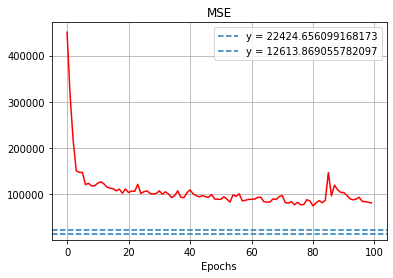

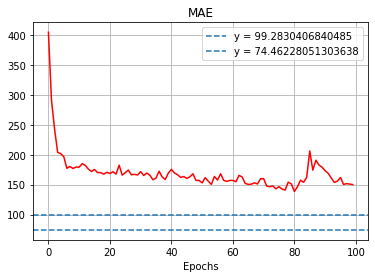

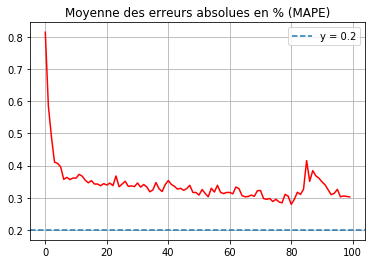

In [22]:
plt.plot(df['mean_squared_error'],'r')
plt.title('MSE')
plt.xlabel('Epochs')
plt.axhline(np.mean(y_train**2)*0.04,ls='--',label='y = ' + str(0.04*np.mean(y_train**2)))
plt.axhline(np.mean(y_train**2)*0.15**2,ls='--',label='y = ' + str(0.15**2*np.mean(y_train**2)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mean_absolute_error'],'r')
plt.title('MAE')
plt.xlabel('Epochs')
plt.axhline(0.2*np.mean(y_train),ls='--',label='y = ' +str(0.2*np.mean(y_train)))
plt.axhline(0.15*np.mean(y_train),ls='--',label='y = ' +str(0.15*np.mean(y_train)))
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mean_absolute_error']/np.mean(y_train),'r') # MAPE
plt.axhline(0.20,ls='--',label='y = 0.2')
plt.grid()
plt.title('Moyenne des erreurs absolues en % (MAPE)')
plt.legend()
plt.show()


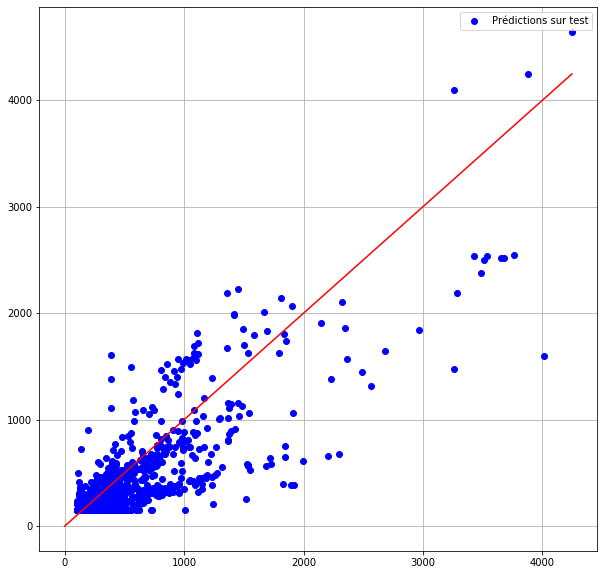

In [24]:
plt.figure(figsize=(10,10))
plt.plot(y_test,model.predict(x_test),'bo',label='Prédictions sur test')
u = min(y_test)
m = max(y_test)
x = np.arange(0,m)
plt.plot(x,x,'r')
#plt.plot(x,x+0.20*x,'--g')
#plt.plot(x,x-0.20*x,'--g')
#plt.xlim(0,5000)
plt.legend()
plt.grid()
plt.show()

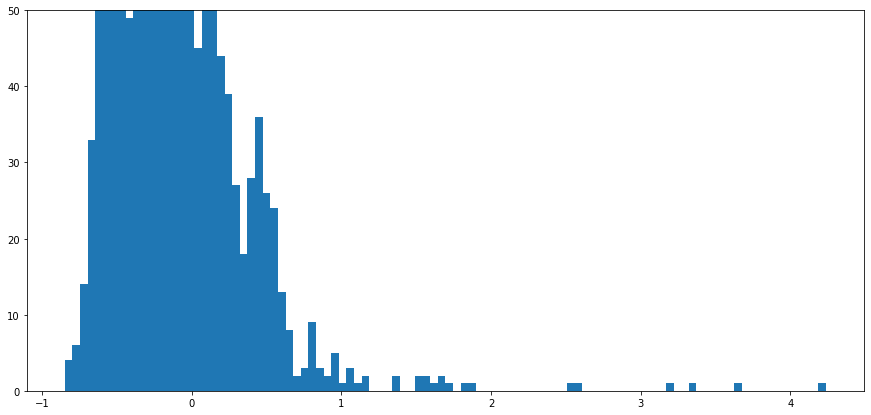

In [23]:
yt = y_test.reshape(y_test.shape[0],1)
plt.figure(figsize=(15,7))
plt.hist(((model.predict(x_test)-yt)/yt),bins=100)
plt.ylim(0,50)
plt.show()

Remarque : 

   - Avec toutes les données, on observe des valeurs aberrantes : vers +250 (250 000% d'erreur). Cela peut s'expliquer par la présence d'une rivière avec un très faible débit. 

   - Lorsqu'on enlève les débits <70, on a perdu environ 19% des données, on observe moins le phénomène des valeurs aberrantes. ( max : 15 ). 
    
   -  Lorsqu'on enlève les débits <100, on a perdu environ 26% des données, le max est maintenant de 6. 
    
Avec des valeurs de débits assez grandes, on arrive à limiter l'erreur relative

## Save the model

In [276]:
model.save('../Models/test.h5')